In [2]:
import numpy as np
from Utils import *

# Load the data
training_data = np.load('training_data.npy')
valid_periods = np.load('valid_periods.npy')
categories = np.load('categories.npy')

In [3]:
dataset, labels = build_sequences_optimized(training_data, valid_periods)

Dataset shape:  (48000, 200)


In [4]:
train_data, train_labels, test_data, test_labels = split_dataset(dataset, labels)

Train data shape:  (38400, 200)
Test data shape:  (9600, 200)


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import MultiHeadAttention, Dropout, LayerNormalization
from tensorflow.keras.optimizers import Adam

# Define the Transformer block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation='relu')(x)
    x = Dense(inputs.shape[-1])(x)
    x = Dropout(dropout)(x)
    return x + res

# Define the model
def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    x = LayerNormalization(epsilon=1e-6)(x)
    for dim in mlp_units:
        x = Dense(dim, activation='relu')(x)
        x = Dropout(mlp_dropout)(x)
    outputs = Dense(18)(x)
    return Model(inputs, outputs)

In [6]:
import optuna as op
from optuna.integration import KerasPruningCallback
from optuna.trial import TrialState

def objective(trial):
    # Parameters
    INPUT_SHAPE = (1, 200)
    HEAD_SIZE = trial.suggest_categorical('HEAD_SIZE', [16, 32, 64])
    NUM_HEADS = trial.suggest_categorical('NUM_HEADS', [2, 4, 8])
    FF_DIM = trial.suggest_categorical('FF_DIM', [32, 64, 128])
    NUM_TRANSFORMER_BLOCKS = trial.suggest_categorical('NUM_TRANSFORMER_BLOCKS', [2, 4, 8])
    MLP_UNITS = trial.suggest_categorical('MLP_UNITS', [32, 64, 128])
    DROPOUT = trial.suggest_categorical('DROPOUT', [0.1, 0.2, 0.3])
    MLP_DROPOUT = trial.suggest_categorical('MLP_DROPOUT', [0.1, 0.2, 0.3])
    LR = trial.suggest_categorical('LR', [0.0001, 0.0005, 0.001])
    
    MLP_UNITS = [MLP_UNITS]
    
    # Build and compile the model
    model = build_model(INPUT_SHAPE, HEAD_SIZE, NUM_HEADS, FF_DIM, NUM_TRANSFORMER_BLOCKS, MLP_UNITS, DROPOUT, MLP_DROPOUT)
    model.compile(loss='mse', optimizer=Adam(learning_rate=LR))
    
    # Reshape data for Transformer [samples, timesteps, features]
    train_X = train_data.reshape((train_data.shape[0], 1, train_data.shape[1]))
    test_X = test_data.reshape((test_data.shape[0], 1, test_data.shape[1]))
    
    # Fit the model
    history = model.fit(train_X, train_labels, epochs=100, batch_size=64, validation_data=(test_X, test_labels), callbacks=[KerasPruningCallback(trial, "val_loss")], verbose=2)
    
    # Make predictions
    yhat = model.predict(test_X)
    predictions = yhat.reshape(yhat.shape[0], -1)
    mse = mean_squared_error(test_labels, predictions)
    return mse

In [ ]:
study_name = "transformer-study"  # Unique identifier of the study.
storage_name = "sqlite:///db.db".format(study_name)
op.delete_study(study_name, storage_name)
study = op.create_study(study_name=study_name, storage=storage_name,direction="maximize", pruner=op.pruners.MedianPruner(), load_if_exists=True)
study.optimize(objective, n_trials=100)
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.vaq

/var/folders/l3/n3yjvx_d2g9dy0ztkyft2th40000gn/T/ipykernel_77984/3498006658.py:3: FutureWarning: delete_study(): Please give all values as keyword arguments. See https://github.com/optuna/optuna/issues/3324 for details.
  op.delete_study(study_name, storage_name)
[I 2023-12-12 20:55:19,744] A new study created in RDB with name: transformer-study
2023-12-12 20:55:19.775821: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-12 20:55:19.775849: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-12 20:55:19.775863: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-12 20:55:19.775896: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-12 20:55:19.775919: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Cr

Epoch 1/100


/var/folders/l3/n3yjvx_d2g9dy0ztkyft2th40000gn/T/ipykernel_77984/1661807923.py:28: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  history = model.fit(train_X, train_labels, epochs=100, batch_size=64, validation_data=(test_X, test_labels), callbacks=[KerasPruningCallback(trial, "val_loss")], verbose=2)
2023-12-12 20:55:24.745738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU

600/600 - 124s - loss: 0.0970 - val_loss: 0.0747 - 124s/epoch - 206ms/step
Epoch 2/100
600/600 - 73s - loss: 0.0789 - val_loss: 0.0743 - 73s/epoch - 121ms/step
Epoch 3/100
600/600 - 72s - loss: 0.0783 - val_loss: 0.0731 - 72s/epoch - 119ms/step
Epoch 4/100
600/600 - 72s - loss: 0.0779 - val_loss: 0.0760 - 72s/epoch - 120ms/step
Epoch 5/100
600/600 - 71s - loss: 0.0777 - val_loss: 0.0734 - 71s/epoch - 118ms/step
Epoch 6/100
600/600 - 70s - loss: 0.0776 - val_loss: 0.0737 - 70s/epoch - 117ms/step
Epoch 7/100
600/600 - 71s - loss: 0.0774 - val_loss: 0.0751 - 71s/epoch - 119ms/step
Epoch 8/100
600/600 - 70s - loss: 0.0774 - val_loss: 0.0748 - 70s/epoch - 116ms/step
Epoch 9/100
600/600 - 70s - loss: 0.0773 - val_loss: 0.0731 - 70s/epoch - 116ms/step
Epoch 10/100
600/600 - 70s - loss: 0.0774 - val_loss: 0.0734 - 70s/epoch - 116ms/step
Epoch 11/100
600/600 - 70s - loss: 0.0773 - val_loss: 0.0744 - 70s/epoch - 117ms/step
Epoch 12/100
600/600 - 70s - loss: 0.0773 - val_loss: 0.0726 - 70s/epoch 

[I 2023-12-12 22:53:40,904] Trial 0 finished with value: 0.0719843470591514 and parameters: {'HEAD_SIZE': 16, 'NUM_HEADS': 4, 'FF_DIM': 64, 'NUM_TRANSFORMER_BLOCKS': 8, 'MLP_UNITS': 64, 'DROPOUT': 0.2, 'MLP_DROPOUT': 0.1, 'LR': 0.0005}. Best is trial 0 with value: 0.0719843470591514.


Epoch 1/100


/var/folders/l3/n3yjvx_d2g9dy0ztkyft2th40000gn/T/ipykernel_77984/1661807923.py:28: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  history = model.fit(train_X, train_labels, epochs=100, batch_size=64, validation_data=(test_X, test_labels), callbacks=[KerasPruningCallback(trial, "val_loss")], verbose=2)


MAE: 0.22996370487575682
MSE: 0.0720632036644187
RMSE: 0.2684459045402233


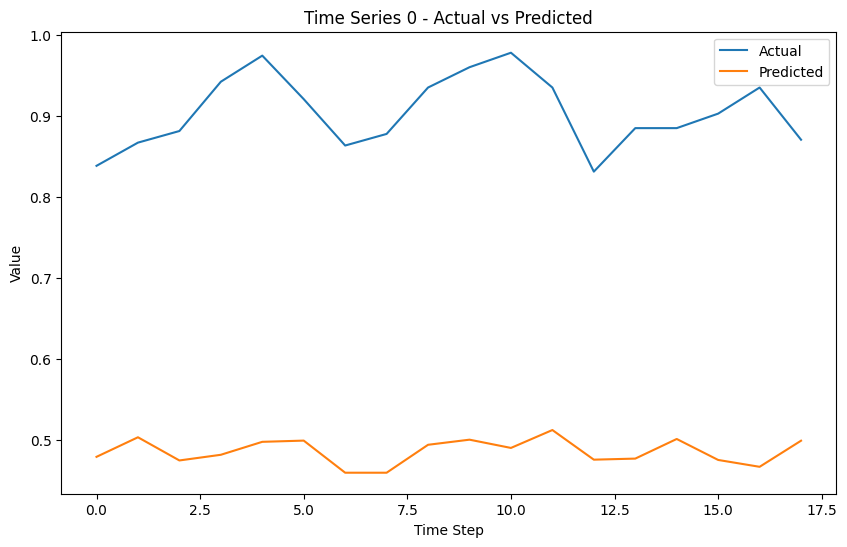

In [9]:
evaluate_model(predictions, test_labels)
for i in range(1):
    # Plot the first 5 predictions
    plot_predictions(predictions, test_labels, i)